1. Decision Tree Regression
1. rfrging
2. RandomForest
3. AdaBoost
4. Gradient Boosting (XGBoost)
5. Stacking
6. Blending
7. Cascading
8. Mixture of Experts


Clone GitHub repo to extract helpful tools

In [ ]:
# Clone repo
!git clone https://github.com/bchenley/MachineLearningPortfolio.git

Cloning into 'MachineLearningPortfolio'...
remote: Enumerating objects: 1538, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (151/151), done.
remote: Total 1538 (delta 109), reused 10 (delta 10), pack-reused 1376
Receiving objects: 100% (1538/1538), 13.17 MiB | 3.82 MiB/s, done.
Resolving deltas: 100% (860/860), done.
Updating files: 100% (53/53), done.


In [ ]:
# go to repo src
%cd MachineLearningPortfolio/src

/content/MachineLearningPortfolio/src


In [ ]:
# Install repo requirements (if needed)
# !pip install -r requirments.txt --quiet

Import libraries/modules.

In [ ]:
from google.colab import drive

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
import seaborn as sns

# helpers from repo
from eda import describe, annotate_bar, Descriptor
from model_selection import train_test_split_df
from stats import info_gain
from metrics import calculate_scores, evaluate_model

# models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

# model selection tools
from sklearn.model_selection import GridSearchCV, ShuffleSplit, RepeatedKFold, cross_val_score, train_test_split
from sklearn.model_selection import cross_validate, cross_val_predict

# metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer


Mount Google Drive if that is where your data is.

In [ ]:
# Mount google drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


## Data

In [ ]:
# Change paths to wherever your data is
data_path = '/content/drive/MyDrive/IK/Assignments/Bagging_Boosting/train.csv'

In [ ]:
# Load training and test data
house_price_data = pd.read_csv(data_path)

house_price_data.drop(columns = ['Id'], inplace = True)

Specify the target and features.

In [ ]:
y_name = ['SalePrice'] # target
X_name = house_price_data.drop(columns = y_name).columns.tolist() # features

# categorical features
X_name_cat = house_price_data[X_name].select_dtypes(include = ['object']).columns.tolist()
X_name_num = [name for name in X_name if name not in X_name_cat]

# Convert numerical features and target to floats
house_price_data[X_name_num + y_name] = house_price_data[X_name_num + y_name].astype(float)

print(f"{len(y_name)} targets")
print(f"{len(X_name)} features")
print(f"{len(X_name_cat)} categorical features: {X_name_cat}")
print(f"{len(X_name_num)} numeric features: {X_name_num}")

1 targets
79 features
43 categorical features: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
36 numeric features: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBl

Use our custom `describe` method to provide more comprehensive summary of our data.

In [ ]:
# Summarize categorical features
describe(house_price_data[X_name_cat])

,count,unique,top,freq,Mode,Skew,Dtype,Cardinality,missing
MSZoning,1460,5,RL,1151,RL,NaN,object,5,0
Street,1460,2,Pave,1454,Pave,NaN,object,2,0
Alley,91,2,Grvl,50,Grvl,NaN,object,2,1369
LotShape,1460,4,Reg,925,Reg,NaN,object,4,0
LandContour,1460,4,Lvl,1311,Lvl,NaN,object,4,0
Utilities,1460,2,AllPub,1459,AllPub,NaN,object,2,0
LotConfig,1460,5,Inside,1052,Inside,NaN,object,5,0
LandSlope,1460,3,Gtl,1382,Gtl,NaN,object,3,0
Neighborhood,1460,25,NAmes,225,NAmes,NaN,object,25,0
Condition1,1460,9,Norm,1260,Norm,NaN,object,9,0


In [ ]:
# Summarize numeric features and target
describe(house_price_data[X_name_num + y_name])

,count,mean,std,min,25%,50%,75%,max,Mode,Skew,Dtype,Cardinality,missing
MSSubClass,1460,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0,20.0,1.406210,float64,15,0
LotFrontage,1201,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0,60.0,NaN,float64,110,259
LotArea,1460,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0,7200.0,12.195142,float64,1073,0
OverallQual,1460,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0,5.0,0.216721,float64,10,0
OverallCond,1460,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0,5.0,0.692355,float64,9,0
YearBuilt,1460,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0,2006.0,-0.612831,float64,112,0
YearRemodAdd,1460,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0,1950.0,-0.503044,float64,61,0
MasVnrArea,1452,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0,0.0,NaN,float64,327,8
BsmtFinSF1,1460,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0,0.0,1.683771,float64,637,0
BsmtFinSF2,1460,46.549315,161.319273,0.0,0.00,0.0,0.00,1474.0,0.0,4.250888,float64,144,0


In [ ]:
# Summarize categorical features
describe(house_price_data[X_name_cat])

,count,unique,top,freq,Mode,Skew,Dtype,Cardinality,missing
MSZoning,1460,5,RL,1151,RL,NaN,object,5,0
Street,1460,2,Pave,1454,Pave,NaN,object,2,0
Alley,91,2,Grvl,50,Grvl,NaN,object,2,1369
LotShape,1460,4,Reg,925,Reg,NaN,object,4,0
LandContour,1460,4,Lvl,1311,Lvl,NaN,object,4,0
Utilities,1460,2,AllPub,1459,AllPub,NaN,object,2,0
LotConfig,1460,5,Inside,1052,Inside,NaN,object,5,0
LandSlope,1460,3,Gtl,1382,Gtl,NaN,object,3,0
Neighborhood,1460,25,NAmes,225,NAmes,NaN,object,25,0
Condition1,1460,9,Norm,1260,Norm,NaN,object,9,0


Drop features with too many missing values.



In [ ]:
data_description = describe(house_price_data[X_name + y_name])

pct_missing = .20

idx_missing_discard = np.where((data_description['missing'].values / house_price_data.shape[0] > 0.20))[0]
columns_missing_discard = house_price_data.columns[idx_missing_discard].tolist()

if len(columns_missing_discard) > 0:
  print(f"{len(columns_missing_discard)} features with more than {pct_missing*100}% missing data. Dropping them.")
  house_price_data.drop(columns = columns_missing_discard, inplace = True)
  print("Dropped")

5 features with more than 20.0% missing data. Dropping them.
Dropped


Update variable names

In [ ]:
X_name = house_price_data.drop(columns = y_name).columns.tolist() # features

# categorical features
X_name_cat = house_price_data[X_name].select_dtypes(include = ['object']).columns.tolist()
X_name_num = [name for name in X_name if name not in X_name_cat]

print(f"{len(y_name)} targets")
print(f"{len(X_name)} features")
print(f"{len(X_name_cat)} categorical features: {X_name_cat}")
print(f"{len(X_name_num)} numeric features: {X_name_num}")

1 targets
74 features
38 categorical features: ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']
36 numeric features: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF

Fill missing data in numeric features with their respective median and categorical features with their mode.

In [ ]:
# Fill missing numeric values with median
for x_name_num in X_name_num:
    house_price_data[x_name_num] = house_price_data[x_name_num].fillna(house_price_data[x_name_num].median())

# Fill missing categorical values with mode
for x_name_cat in X_name_cat:
    house_price_data[x_name_cat] = house_price_data[x_name_cat].fillna(house_price_data[x_name_cat].mode()[0])

Confirm that there is no missing data.

In [ ]:
data_summary = describe(house_price_data)

print(f"Any missing data? {data_summary.loc[:, 'missing'].sum() > 0}")

Any missing data? False


Split data into training and test sets.

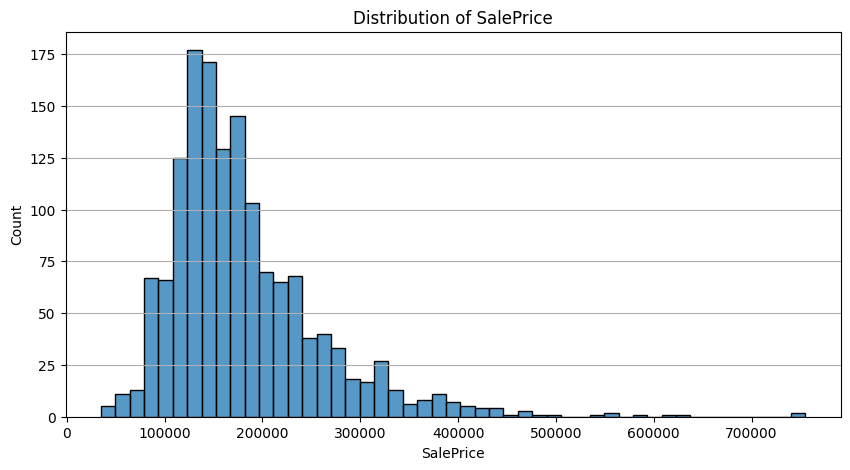

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.histplot(data = house_price_data,
             x = y_name[0]) ;
ax.yaxis.grid(True)
ax.set_title(f"Distribution of {y_name[0]}") ;

plt.show()

In [ ]:
# Quick description of target
data_summary.loc[data_summary.index == y_name[0]].round(2)

,count,mean,std,min,25%,50%,75%,max,Mode,Skew,Dtype,Cardinality,missing
SalePrice,1460,180921.2,79442.5,34900.0,129975.0,163000.0,214000.0,755000.0,140000.0,1.88,float64,663,0


Explore categorical features.

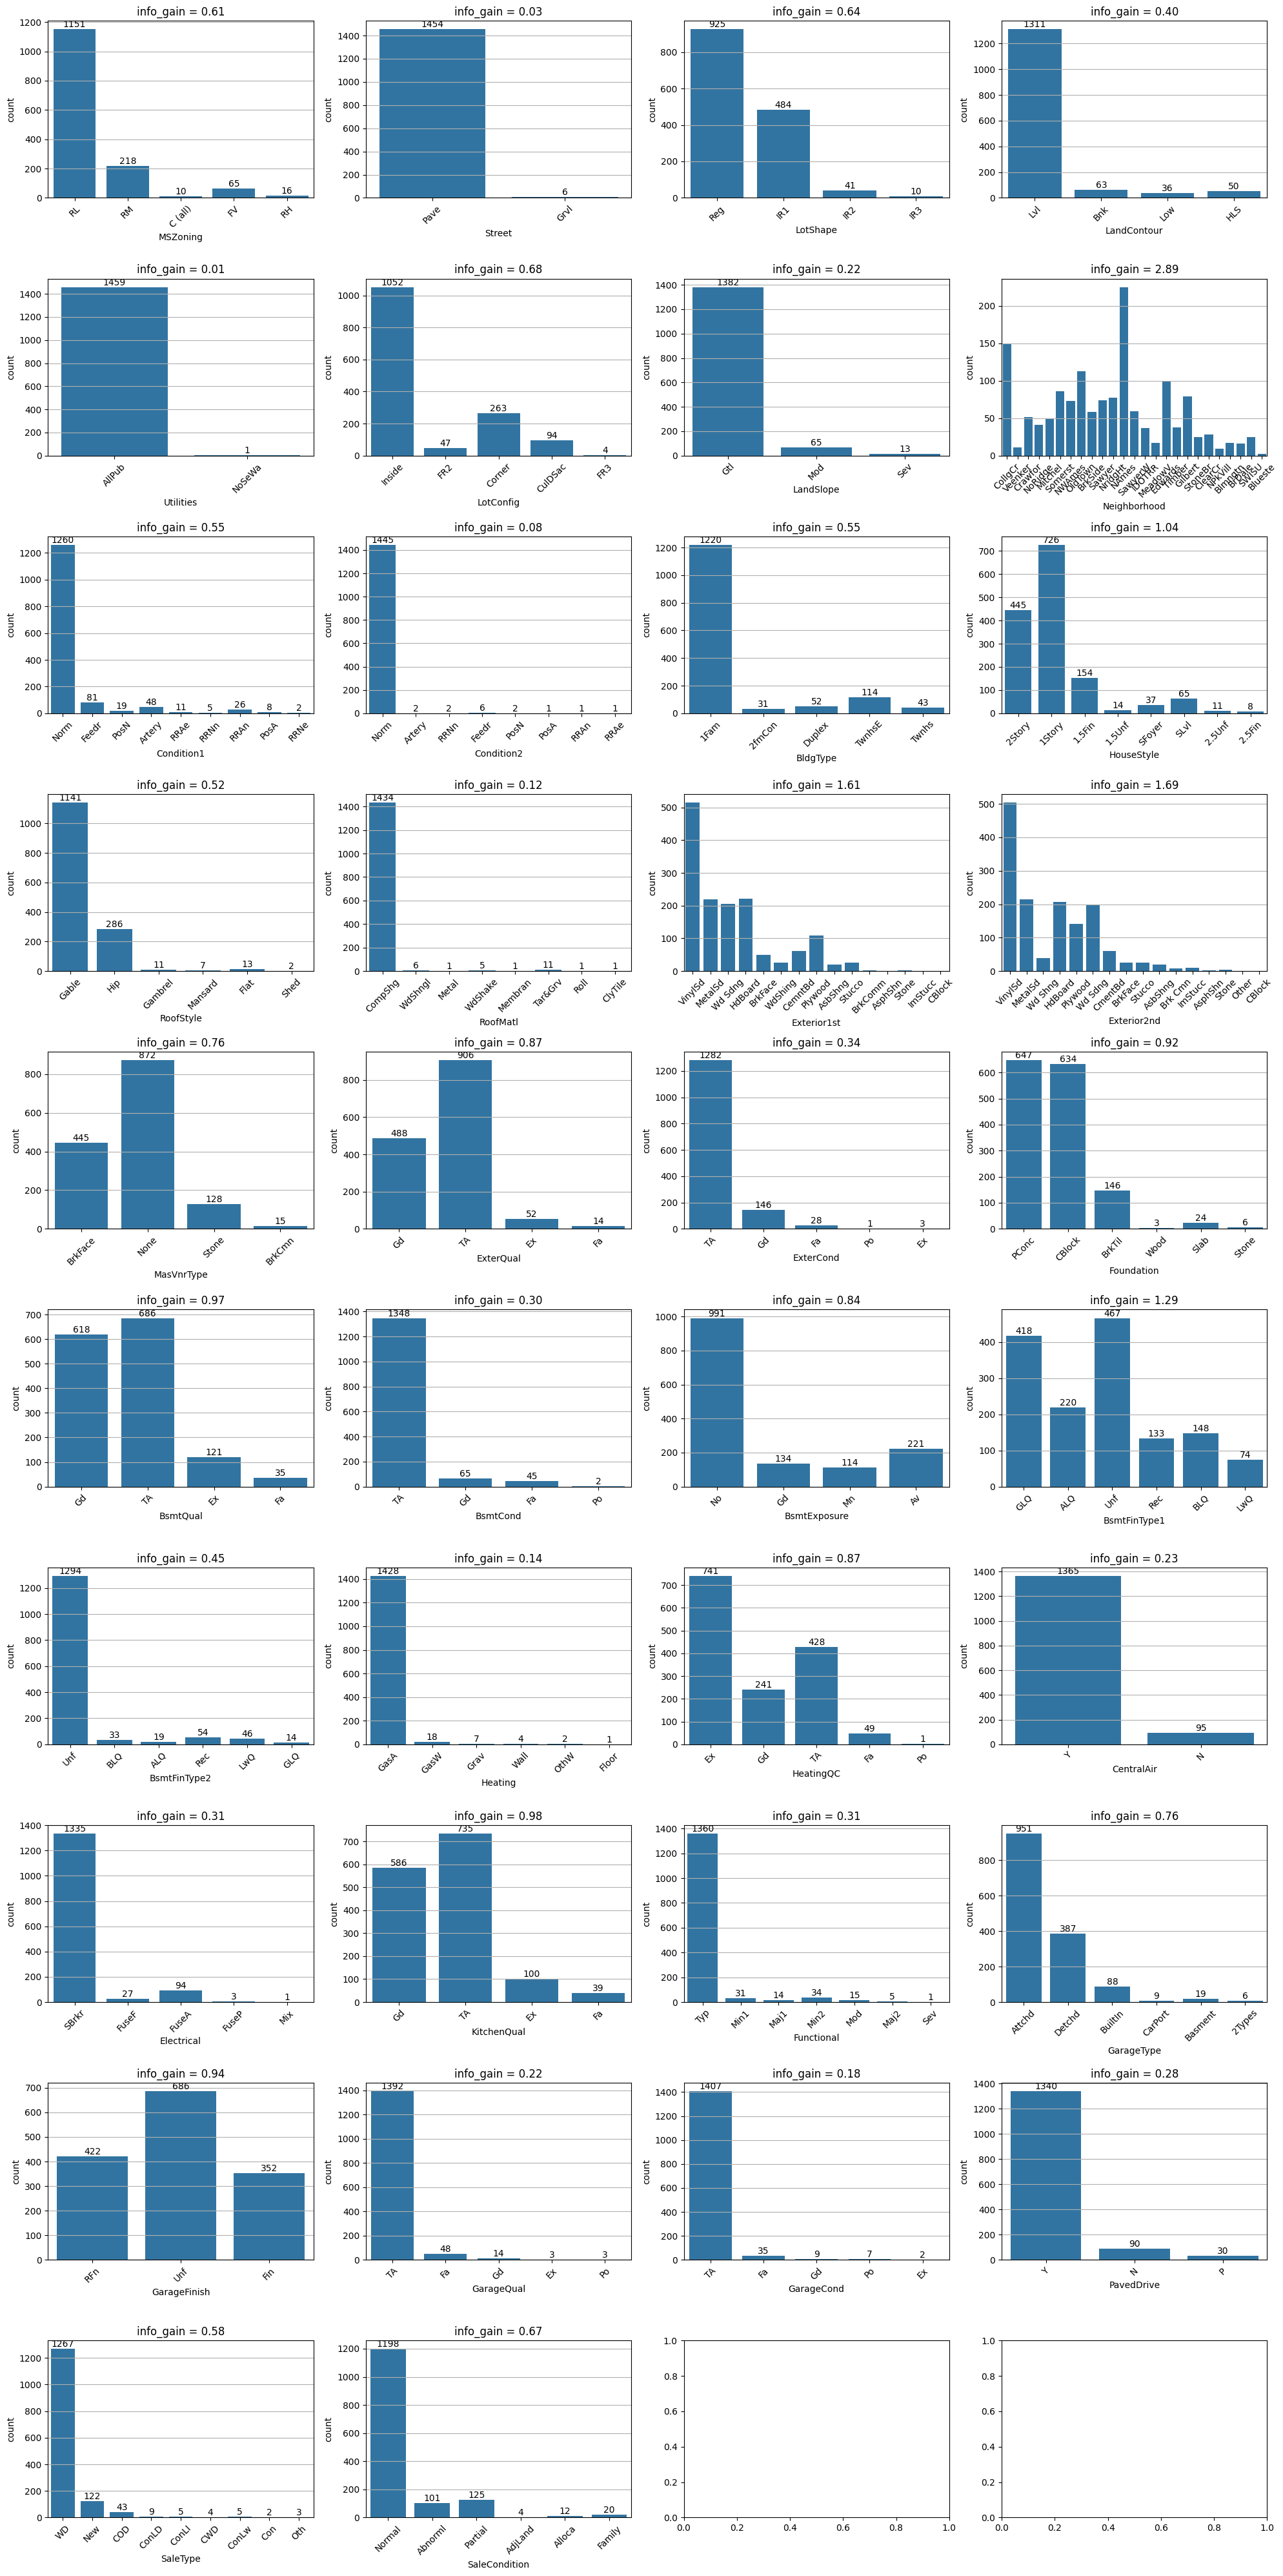

In [ ]:
fig, ax = plt.subplots(10, 4, figsize = (20, 40))

axf = ax.flatten()
for i,x_name_cat in enumerate(X_name_cat):
  # Plot the class count of each variable
  sns.countplot(data = house_price_data,
                x = x_name_cat,
                ax = axf[i])
  axf[i].yaxis.grid(True)

  ig = info_gain(house_price_data[x_name_cat], house_price_data[y_name[0]])
  axf[i].set_title(f"info_gain = {ig:.2f}") ; # f"Distribution of {x_name_cat}"

  # Slant the labels for clarity
  for label in axf[i].get_xticklabels():
    label.set_rotation(45)

  # Show count at top of bar if there aren't too many classes
  if house_price_data[x_name_cat].nunique() <= 10:
    annotate_bar(axf[i], decimals = 0)

plt.tight_layout()
plt.show()

In [ ]:
impurity_method = 'shannon'

info_gain_cat = pd.DataFrame(index = X_name_cat, columns = [impurity_method])

for i,x_name_cat in enumerate(X_name_cat):
  ig = info_gain(house_price_data[x_name_cat], house_price_data[y_name[0]], method = impurity_method)

  info_gain_cat.loc[x_name_cat, impurity_method] = ig

info_gain_cat.index.name = 'Feature'

info_gain_cat.sort_values(by = impurity_method, ascending = False, inplace = True)

info_gain_cat.round(2)

,shannon
Feature,
Neighborhood,2.890999
Exterior2nd,1.69162
Exterior1st,1.611405
BsmtFinType1,1.289605
HouseStyle,1.040501
KitchenQual,0.975879
BsmtQual,0.972212
GarageFinish,0.9413
Foundation,0.919137


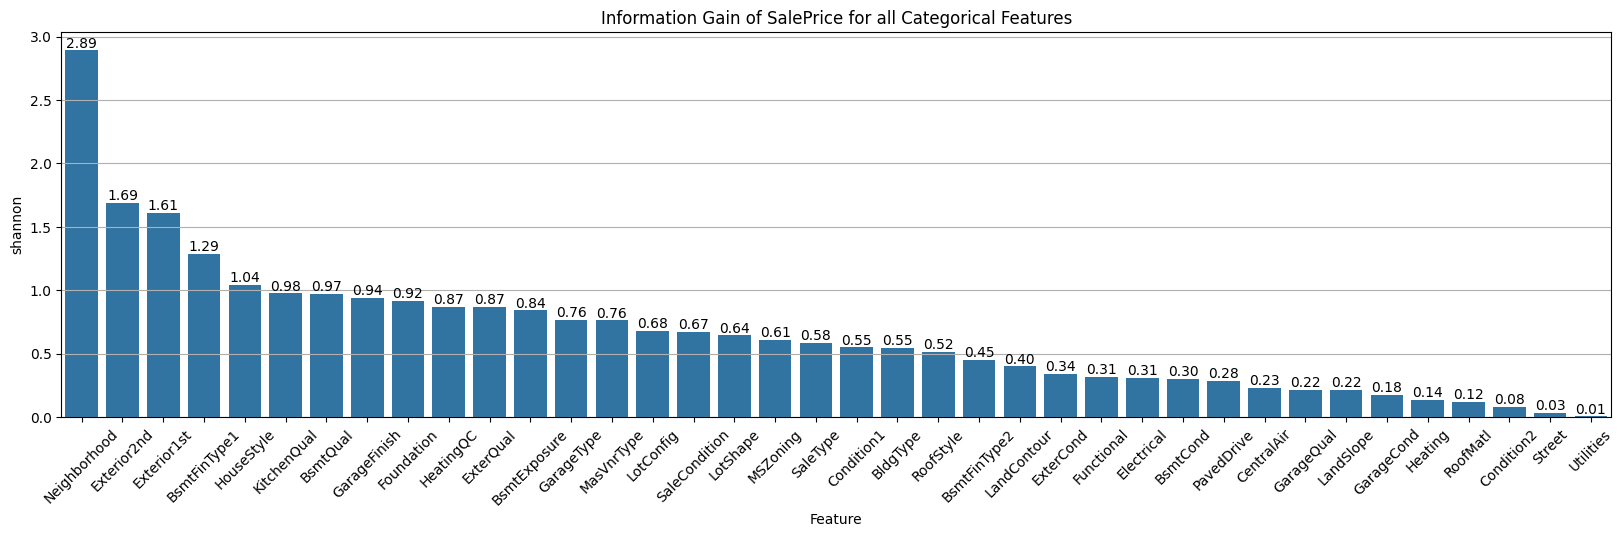

In [ ]:
fig, ax = plt.subplots(figsize = (20, 5))
sns.barplot(data = info_gain_cat.reset_index(),
            x = 'Feature',
            y = impurity_method,
            ax = ax) ;
ax.set_title("Information Gain of SalePrice for all Categorical Features")
ax.set_ylabel(impurity_method)
ax.set_xticks(ticks = ax.get_xticks(),
              labels = ax.get_xticklabels(),
              rotation = 45) ;
ax.yaxis.grid(True)

annotate_bar(ax)

Discard categorical features with low information gain

In [ ]:
info_gain_threshod = 0.1

X_name_cat_low_info_gain = info_gain_cat.loc[info_gain_cat[impurity_method] < info_gain_threshod].index.tolist()

print(f"Features with very low InfoGain: {X_name_cat_low_info_gain}")

X_name_cat = [name for name in X_name_cat if name not in X_name_cat_low_info_gain]

print(f"{len(X_name_cat)} categorical features: {X_name_cat}")

# drop low info gain features
house_price_data.drop(columns = X_name_cat_low_info_gain, inplace = True)

# Reset features names
X_name = X_name_num + X_name_cat

Features with very low InfoGain: ['Condition2', 'Street', 'Utilities']
35 categorical features: ['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']


Explore numeric features

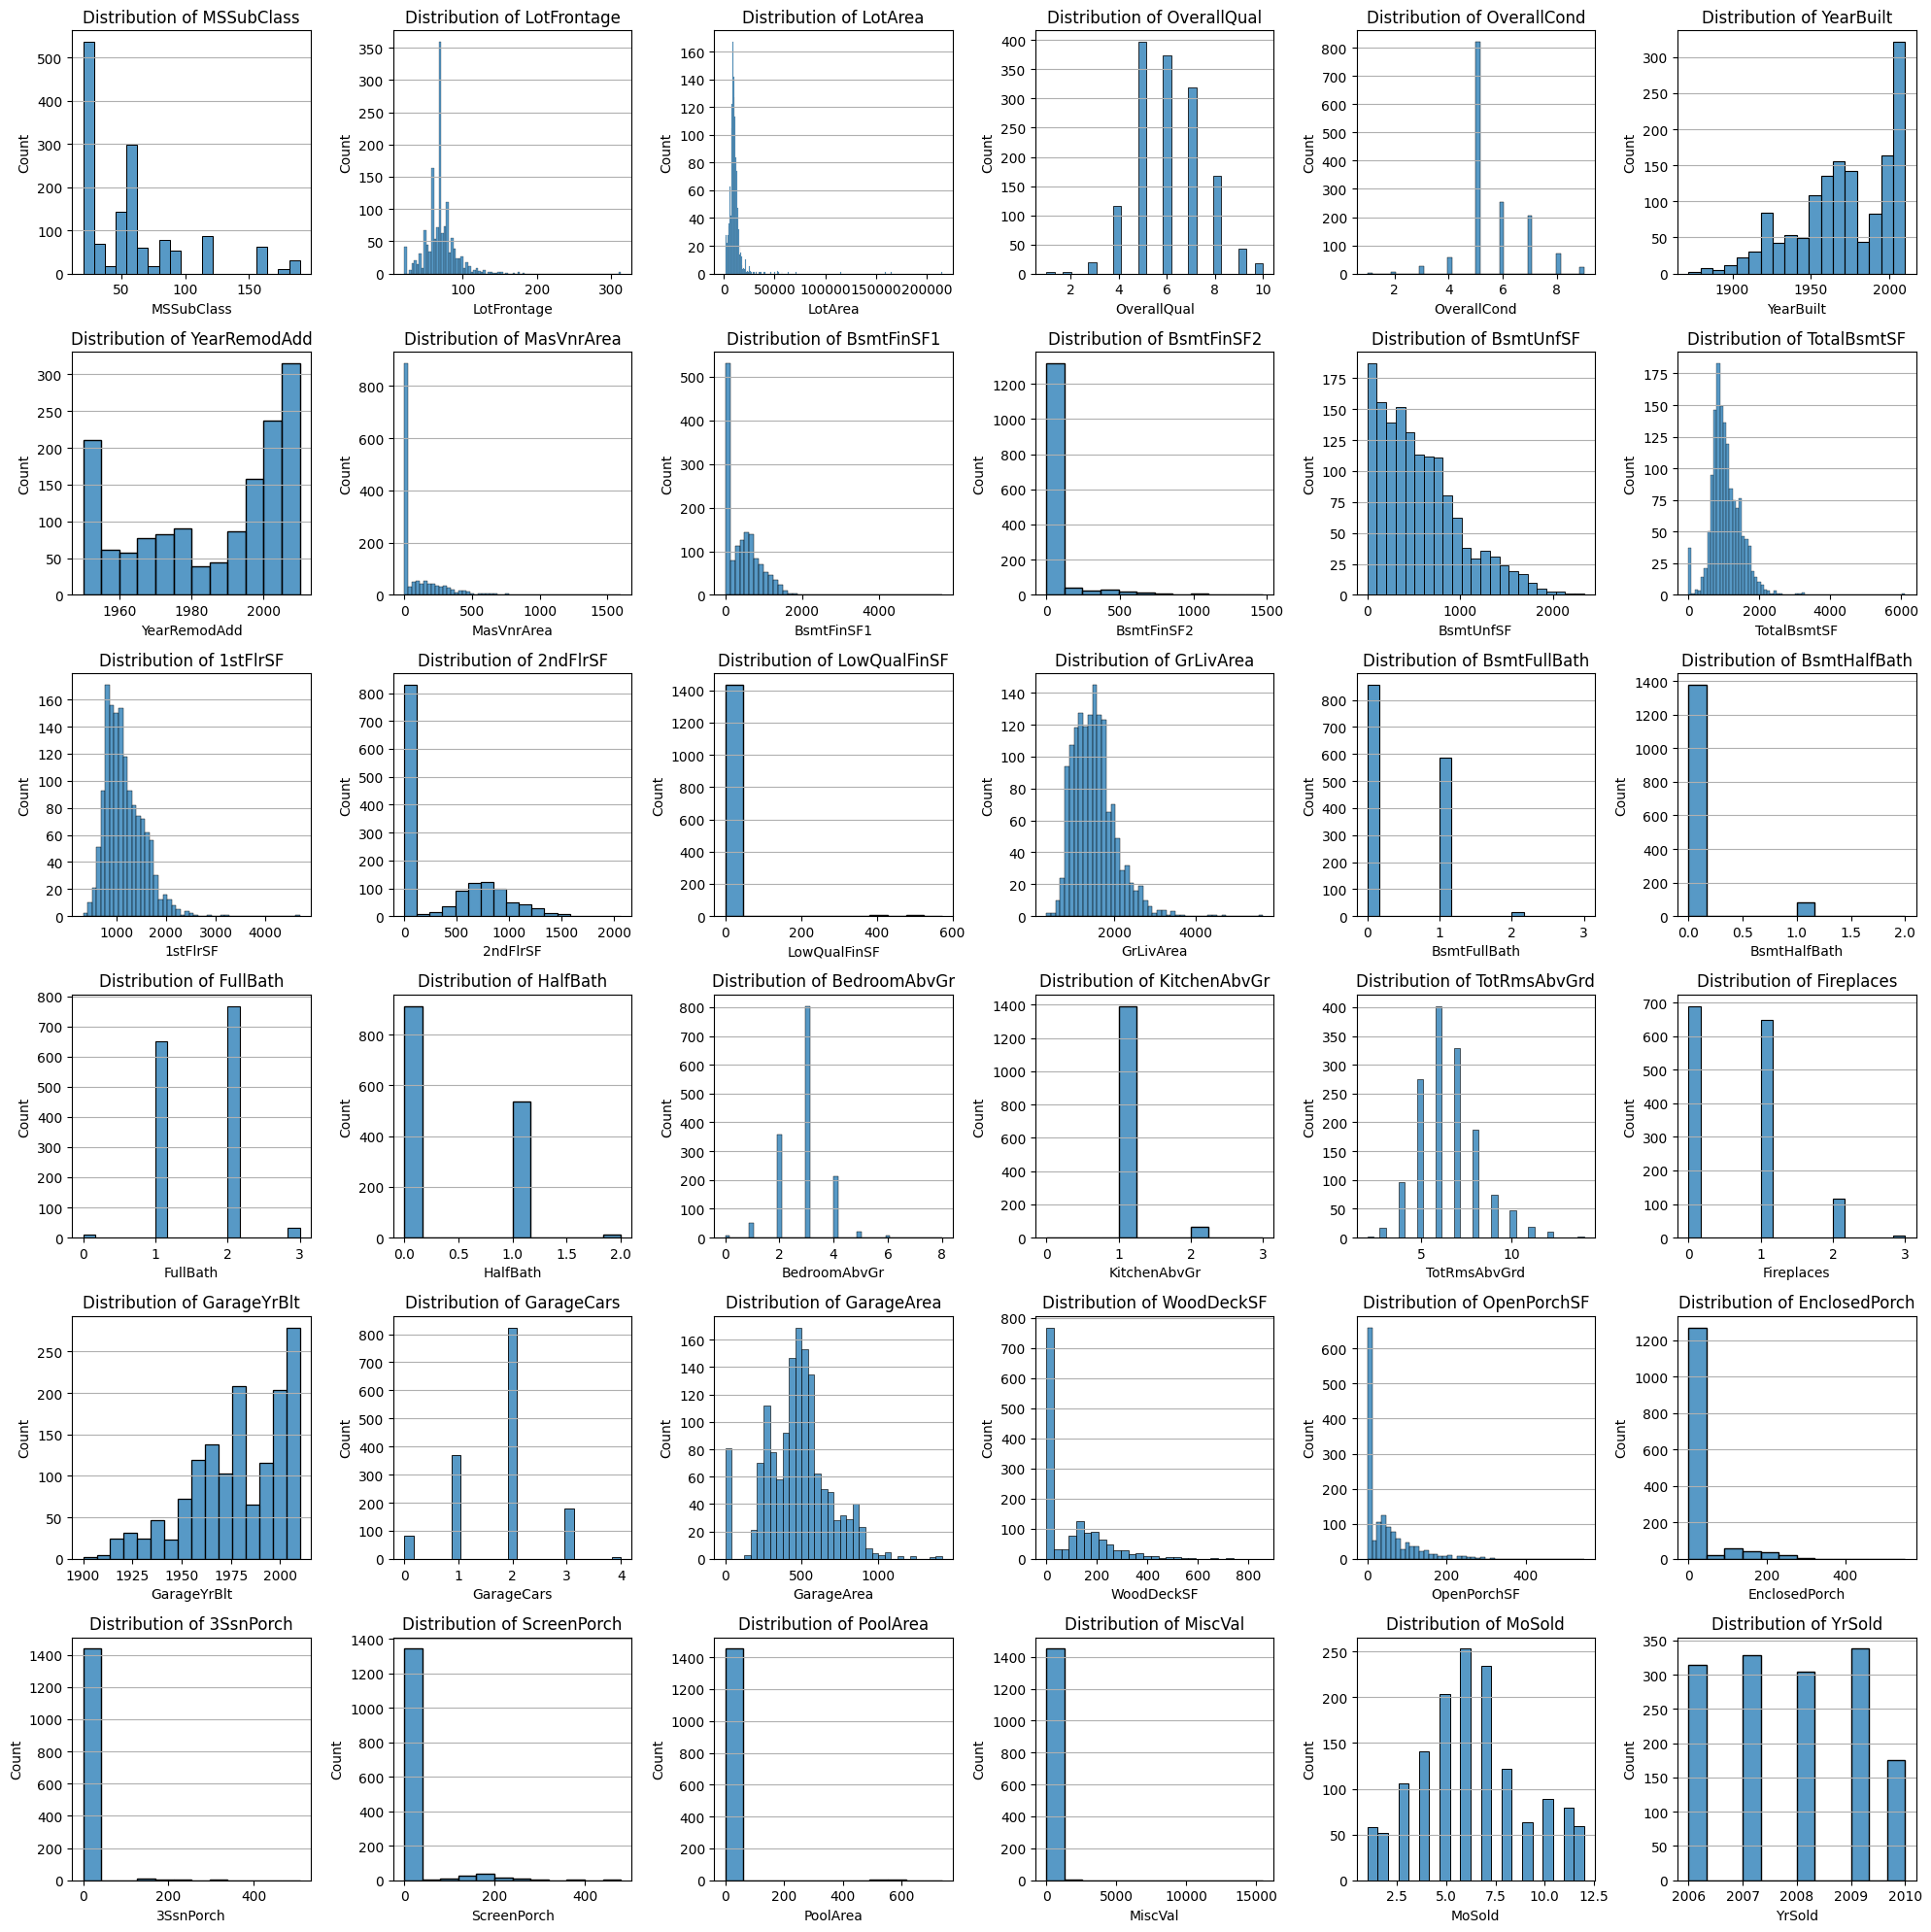

In [ ]:
fig, ax = plt.subplots(6, 6, figsize = (20, 20))

axf = ax.flatten()

for i,x_name_num in enumerate(X_name_num):
  # Plot the distribution of each variable
  sns.histplot(data = house_price_data,
               x = x_name_num,
               ax = axf[i])
  axf[i].yaxis.grid(True)
  axf[i].set_title(f"Distribution of {x_name_num}") ;

# Turn off extra plots
for j in range(i+1, len(axf)):
  axf[j].axis('off')

plt.tight_layout()
plt.show()

Clip outliers (if desired)

In [ ]:
# house_price_data_pp = house_price_data.copy()

# # Clip outliers
# for x_name_num in X_name_num:
#   if house_price_data_pp[x_name_num].dtype == float:
#     # Instantiate Descriptor
#     descriptor = Descriptor(house_price_data_pp[x_name_num].values)
#     house_price_data_pp[x_name_num] = descriptor.clip(scale = 3)

Plot the clipped numeric data (if desired)

In [ ]:
# fig, ax = plt.subplots(6, 6, figsize = (20, 20))

# axf = ax.flatten()

# for i,x_name_num in enumerate(X_name_num):
#   # Plot the distribution of each variable
#   sns.histplot(data = house_price_data_pp,
#                x = x_name_num,
#                ax = axf[i])
#   axf[i].yaxis.grid(True)
#   axf[i].set_title(f"Distribution of {x_name_num}") ;

# # Turn off extra plots
# for j in range(i+1, len(axf)):
#   axf[j].axis('off')

# plt.tight_layout()
# plt.show()

Labe-encode or onehot-encode categorical features (if desired).

In [ ]:

house_price_data_encoded = house_price_data.copy() # house_price_data_pp.copy() if you clipped the data

encode_method = 'onehot' # 'label'

if encode_method == 'onehot':
  house_price_data_encoded = pd.get_dummies(house_price_data_encoded,
                                            columns = X_name_cat,
                                            drop_first = True)

  X_name_cat_encoded = house_price_data_encoded.drop(columns = X_name_num + y_name).columns.tolist()

else:
  classes = {}
  for x_name_cat in X_name_cat:
      label_encoder = LabelEncoder()
      house_price_data_encoded[x_name_cat] = label_encoder.fit_transform(house_price_data_encoded[x_name_cat].astype('str'))
      classes[x_name_cat] = label_encoder.classes_.tolist()

  X_name_cat_encoded = X_name_cat

X_name_encoded = X_name_num + X_name_cat_encoded

print(f"{len(X_name_cat_encoded)} onehot features: {X_name}")

187 onehot features: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondit

The data is now ready for modeling.

In [ ]:
scores = {'mae': mean_absolute_error,
          'r2': r2_score}

score_table = pd.DataFrame(index = ['dtr', 'bag', 'rf', 'ada', 'gb', 'stack',
                                    'blend', 'cascading', 'mix'])

for score in scores:
  score_table['train_'+score] = np.nan
  score_table['test_'+score] = np.nan

score_table

,train_mae,test_mae,train_r2,test_r2
dtr,NaN,NaN,NaN,NaN
bag,NaN,NaN,NaN,NaN
rf,NaN,NaN,NaN,NaN
ada,NaN,NaN,NaN,NaN
gb,NaN,NaN,NaN,NaN
stack,NaN,NaN,NaN,NaN
blend,NaN,NaN,NaN,NaN
cascading,NaN,NaN,NaN,NaN
mix,NaN,NaN,NaN,NaN


In [ ]:
random_state = 42

df_train, df_test = train_test_split_df(house_price_data_encoded,
                                        train_size = 0.8,
                                        random_state = random_state)

X_train = df_train[X_name_encoded]
y_train = df_train[y_name]

X_test = df_test[X_name_encoded]
y_test = df_test[y_name]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1168, 223)
y_train shape: (1168, 1)
X_test shape: (292, 223)
y_test shape: (292, 1)


Instantiate a CV strategy.

In [ ]:
random_state = 42

shuffle_split = ShuffleSplit(n_splits = 5,
                             train_size = 0.8,
                             random_state = random_state)

mean_absolute_error_scorer = make_scorer(mean_absolute_error,
                                         greater_is_better = False)
mean_squared_error_scorer = make_scorer(mean_squared_error,
                                        greater_is_better = False)
r2_scorer = make_scorer(r2_score,
                        greater_is_better = True)

## 1. Decision Tree Reggressor

# Key parameters:
  1. max_depth
  2. min_samples_split
  3. min_samples_leaf
  4. max_leaf_nodes

In [ ]:
param_grid_dtr = {'max_depth': [5, 10, 20, 25],
                  'min_samples_split': np.arange(20, 220, 20), # [2, 10, 20, 30, 40, 50],
                  'min_samples_leaf': np.arange(20, 220, 20), #, [1, 5, 10, 15, 20, 25, 30],
                  'max_leaf_nodes': np.arange(0, 60, 5)} # [2, 3, 4, 5, 6]

param_grid_dtr['max_leaf_nodes'][0] = 2

model_dtr = DecisionTreeRegressor(random_state = random_state)

gscv_dtr = GridSearchCV(estimator = model_dtr,
                        param_grid = param_grid_dtr,
                        return_train_score = True,
                        scoring = r2_scorer,
                        cv = shuffle_split,
                        n_jobs = -1,
                        verbose = 3)

gscv_dtr.fit(X_train.values, y_train.values.squeeze()) ;

Fitting 5 folds for each of 4800 candidates, totalling 24000 fits


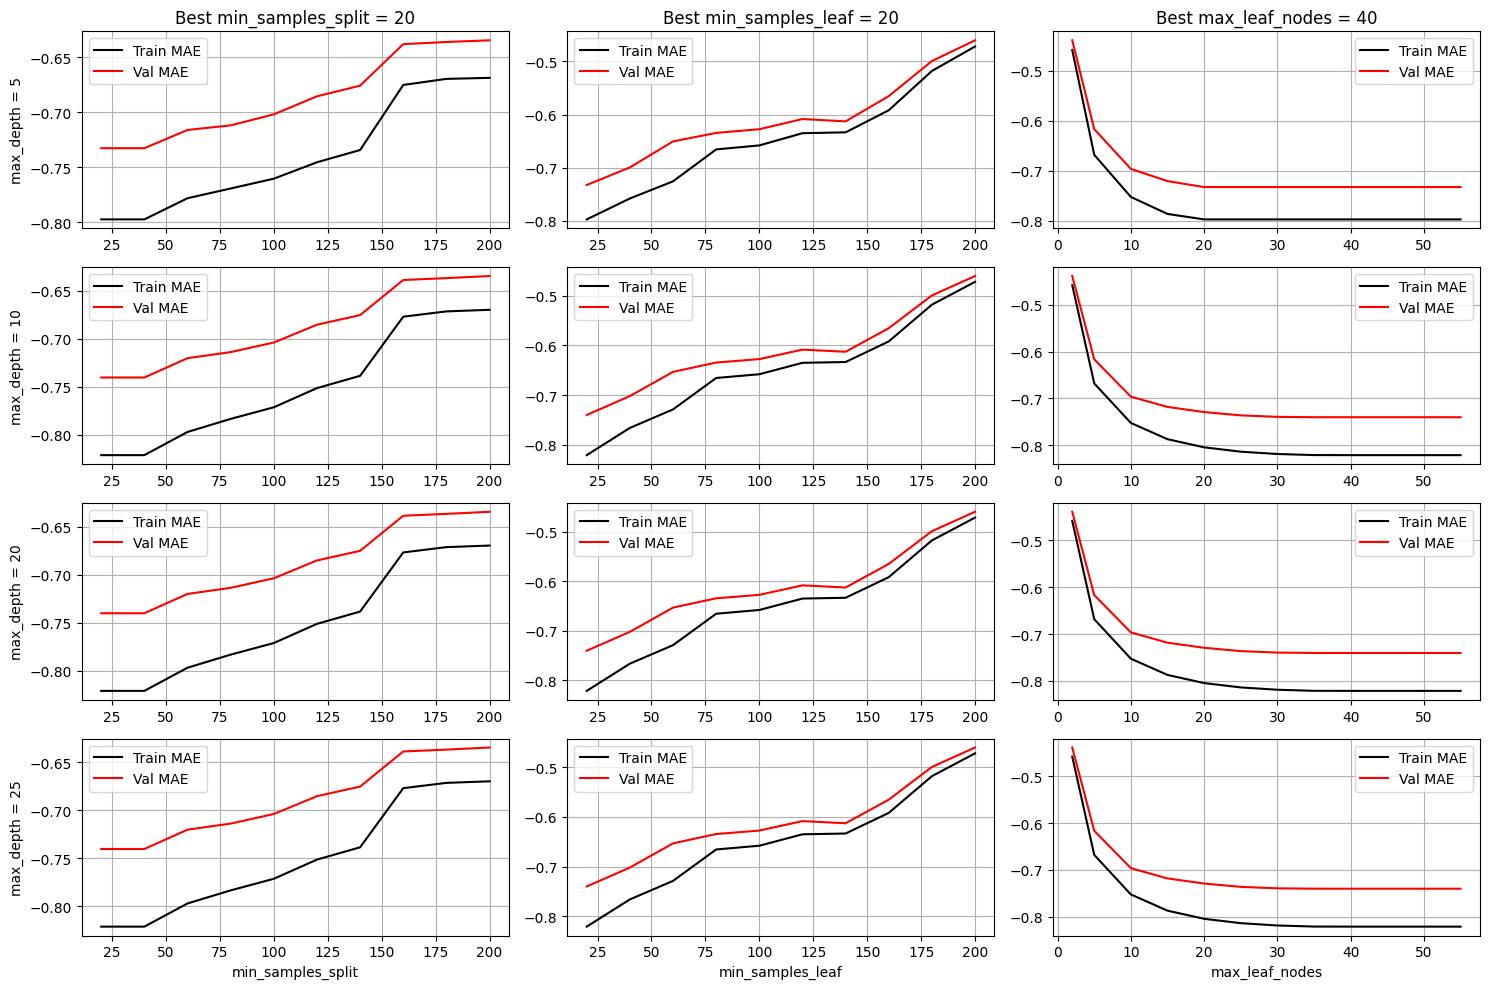

In [107]:
gscv_dtr_cv_results = pd.DataFrame(gscv_dtr.cv_results_)

x_params = [keys for keys in param_grid_dtr if keys != 'max_depth']

rows = len(param_grid_dtr['max_depth'])
cols = len(x_params)

fig, ax = plt.subplots(rows, cols, figsize = (15, 2.5*len(param_grid_dtr['max_depth'])))

for i, max_depth in enumerate(param_grid_dtr['max_depth']):

  df_ = gscv_dtr_cv_results[gscv_dtr_cv_results['param_max_depth'] == max_depth]

  for j,x in enumerate(x_params):
    df_x = df_[np.all([df_['param_'+not_x] == gscv_dtr.best_params_[not_x] for not_x in x_params if not_x != x], axis = 0)]

    ax[i,j].plot(df_x['param_'+x], -df_x['mean_train_score'], 'k' , label = 'Train MAE')
    ax[i,j].plot(df_x['param_'+x], -df_x['mean_test_score'], 'r' ,label = 'Val MAE')

    if i == 0:
      ax[i,j].set_title(f"Best {x} = {gscv_dtr.best_params_[x]}")

    if i == (rows - 1):
      ax[i,j].set_xlabel(x)
    else:
      ax[i,j].set_xlabel(None)

    if j == 0:
      ax[i,j].set_ylabel(f'max_depth = {max_depth}')
    else:
      ax[i,j].set_ylabel(None)

    ax[i,j].grid(True)
    ax[i,j].legend()

plt.tight_layout()
plt.show()

In [108]:
gscv_dtr.best_params_

{'max_depth': 10,
 'max_leaf_nodes': 40,
 'min_samples_leaf': 20,
 'min_samples_split': 20}

In [109]:
dtr_best = gscv_dtr.best_estimator_

train_scores_dtr = evaluate_model(dtr_best,
                                  X = X_train.values, y = y_train.values,
                                  scores = scores)
test_scores_dtr = evaluate_model(dtr_best,
                                 X = X_test.values, y = y_test.values,
                                 scores = scores)

for score in scores:
  score_table.loc['dtr', 'train_'+score] = train_scores_dtr[score]
  score_table.loc['dtr', 'test_'+score] = test_scores_dtr[score]

score_table.iloc[:1].round(3)

,train_mae,test_mae,train_r2,test_r2
dtr,20339.091,23956.065,0.828,0.803


## 2. Bagging Reggressor

# Key parameters:
  1. n_estimators
  2. max_samples
  3. max_features

In [ ]:
param_grid_bag = {'n_estimators': np.arange(0, 110, 10),
                  'max_samples': np.arange(0.05, 0.5, .05), # np.arange(20, 220, 20), #
                  'max_features': np.arange(0.0, 1., 0.25)}

param_grid_bag['n_estimators'][0] = 1
param_grid_bag['max_features'][0] = 0.05

model_bag = BaggingRegressor(estimator = DecisionTreeRegressor(random_state = 42),
                             bootstrap = True,
                             bootstrap_features = True,
                             oob_score = False,
                             n_jobs = -1,
                             random_state = random_state)

gscv_bag = GridSearchCV(estimator = model_bag,
                        param_grid = param_grid_bag,
                        return_train_score = True,
                        scoring = r2_scorer,
                        cv = shuffle_split,
                        n_jobs = -1,
                        verbose = 3)

gscv_bag.fit(X_train.values, y_train.values.squeeze()) ;

Fitting 5 folds for each of 396 candidates, totalling 1980 fits


In [ ]:
gscv_bag_cv_results = pd.DataFrame(gscv_bag.cv_results_)

fig, ax = plt.subplots(1, 3, figsize = (15, 5))

num_features = X_train.shape[1]

x_params = list(param_grid_bag.keys())

for i,x in enumerate(x_params):

  df_x = gscv_bag_cv_results[np.all([gscv_bag_cv_results['param_'+not_x] == gscv_bag.best_params_[not_x] for not_x in x_params if not_x != x], axis = 0)]

  x_values = df_x['param_'+x].values
  if x == 'max_features':
    x_values = np.floor(x_values*num_features).astype(int)
    best_param = np.floor(gscv_bag.best_params_[x] * num_features).astype(int)
  else:
    best_param = gscv_bag.best_params_[x]

  ax[i].plot(x_values, -df_x['mean_train_score'], 'k' , label = 'Train MAE')
  ax[i].plot(x_values, -df_x['mean_test_score'], 'r' ,label = 'Val MAE')

  ax[i].set_title(f"Best {x} = {best_param}")

  ax[i].set_xlabel(x)

  if j == 0:
    ax[i].set_ylabel(f'MAE')
  else:
    ax[i].set_ylabel(None)

  ax[i].grid(True)
  ax[i].legend()

plt.tight_layout()
plt.show()

In [ ]:
gscv_bag.best_params_

{'max_features': 0.9, 'max_samples': 0.4, 'n_estimators': 50}

In [ ]:
bag_best = gscv_bag.best_estimator_

train_scores_bag = evaluate_model(bag_best,
                                  X = X_train.values, y = y_train.values,
                                  scores = scores)
test_scores_bag = evaluate_model(bag_best,
                                 X = X_test.values, y = y_test.values,
                                 scores = scores)

for score in scores:
  score_table.loc['bag', 'train_'+score] = train_scores_bag[score]
  score_table.loc['bag', 'test_'+score] = test_scores_bag[score]

score_table.iloc[:2, :]

,train_mae,test_mae,train_r2,test_r2
dtr,20567.285771,24185.760253,0.826516,0.801096
bag,11301.802215,17619.775046,0.938103,0.876762


## 3. Decision Tree Reggressor

# Key parameters:
  1. min_samples_split
  2. min_samples_leaf
  3. max_leaf_nodes

In [ ]:
param_grid_rfr = {'n_estimators': np.arange(0, 80, 10),
                  'max_samples': np.arange(0.05, 1.05, .05),
                  'max_features': np.arange(0.25, 1.25, 0.25)}

param_grid_rfr['n_estimators'][0] = 1
# param_grid_rfr['max_features'][0] = .1

model_rfr = RandomForestRegressor(bootstrap = True,
                                  random_state = random_state,
                                  n_jobs = -1)

gscv_rfr = GridSearchCV(estimator = model_rfr,
                        param_grid = param_grid_rfr,
                        return_train_score = True,
                        scoring = r2_scorer,
                        cv = shuffle_split,
                        n_jobs = -1,
                        verbose = 3)

gscv_rfr.fit(X_train.values, y_train.values.squeeze()) ;

Fitting 5 folds for each of 640 candidates, totalling 3200 fits


KeyboardInterrupt: 

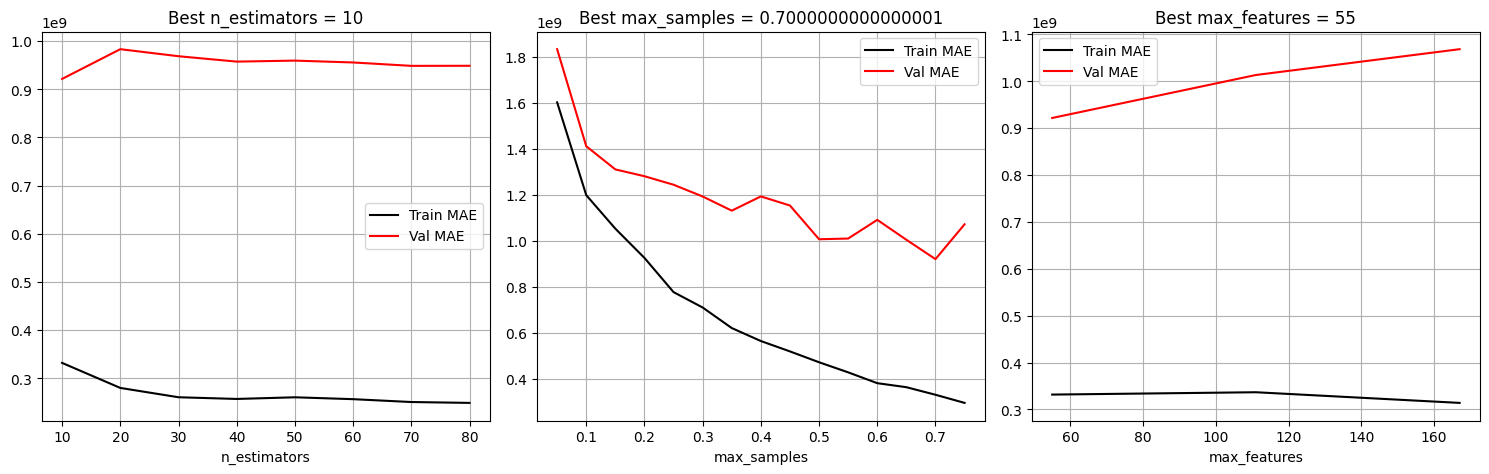

In [ ]:
gscv_rfr_cv_results = pd.DataFrame(gscv_rfr.cv_results_)

fig, ax = plt.subplots(1, 3, figsize = (15, 5))

num_features = X_train.shape[1]

x_params = list(param_grid_rfr.keys())

for i,x in enumerate(x_params):

  df_x = gscv_rfr_cv_results[np.all([gscv_rfr_cv_results['param_'+not_x] == gscv_rfr.best_params_[not_x] for not_x in x_params if not_x != x], axis = 0)]

  x_values = df_x['param_'+x].values
  if x == 'max_features':
    x_values = np.floor(x_values*num_features).astype(int)
    best_param = np.floor(gscv_rfr.best_params_[x] * num_features).astype(int)
  else:
    best_param = gscv_rfr.best_params_[x]

  ax[i].plot(x_values, -df_x['mean_train_score'], 'k' , label = 'Train MAE')
  ax[i].plot(x_values, -df_x['mean_test_score'], 'r' ,label = 'Val MAE')

  ax[i].set_title(f"Best {x} = {best_param}")

  ax[i].set_xlabel(x)

  if j == 0:
    ax[i].set_ylabel(f'MAE')
  else:
    ax[i].set_ylabel(None)

  ax[i].grid(True)
  ax[i].legend()

plt.tight_layout()
plt.show()

In [ ]:
gscv_rfr.best_params_

{'max_features': 0.25, 'max_samples': 0.7000000000000001, 'n_estimators': 10}

In [ ]:
rfr_best = gscv_rfr.best_estimator_

train_scores_rfr = evaluate_model(rfr_best,
                                  X = X_train.values, y = y_train.values,
                                  scores = scores)
test_scores_rfr = evaluate_model(rfr_best,
                                 X = X_test.values, y = y_test.values,
                                 scores = scores)

for score in scores:
  score_table.loc['rf', 'train_'+score] = train_scores_rfr[score]
  score_table.loc['rf', 'test_'+score] = test_scores_rfr[score]

score_table.iloc[:3, :]

,train_mae,test_mae,train_r2,test_r2
dtr,20567.285771,24185.760253,0.826516,0.801096
bag,11301.802215,17619.775046,0.938103,0.876762
rf,10314.328168,18900.240068,0.951872,0.865521


RF: R2 score mean and Standard Deviation: 0.790 (0.052)


<Axes: ylabel='Count'>

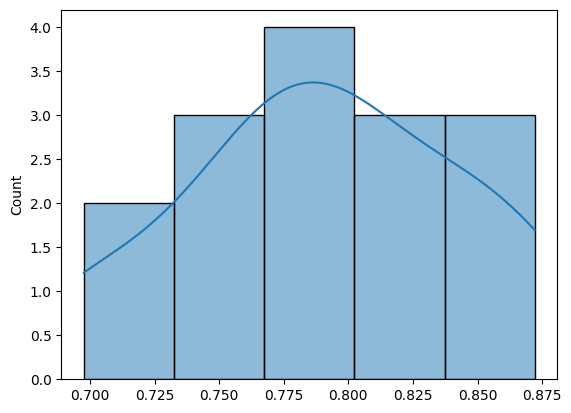

In [ ]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=random_state)
n_scores_rfr = cross_val_score(rfr_best, X_test, y_test, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('RF: R2 score mean and Standard Deviation: %.3f (%.3f)' % (np.mean(n_scores_rfr), np.std(n_scores_rfr)))

sns.histplot(n_scores_rfr, kde = True)